In [5]:
import torch

print("torch version: ", torch.__version__)

torch version:  2.6.0+cpu


In [67]:
import os
import json
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


In [30]:
# Load card attributes from JSON file
def load_card_attributes(file="data/labeled_cards.json"):
    with open(file, "r") as f:
        return {card["id"]: card for card in json.load(f)}

# Load deck graphs from exported GraphML files
def load_deck_graphs(folder="graphs"):
    deck_graphs = []
    for file in os.listdir(folder):
        if file.endswith(".graphml"):
            G = nx.read_graphml(os.path.join(folder, file))
            deck_graphs.append(G)
    return deck_graphs

# Convert NetworkX graphs to PyTorch Geometric format with attributes
def convert_to_pyg(graphs, card_data):
    pyg_graphs = []
    feature_list = ["copies", "cost", "power", "labels", "counter", "type", "traits", "color_Red", "color_Green", "color_Blue", "color_Purple", "color_Black", "color_Yellow"]
    
    for G in graphs:
        for node in G.nodes():
            card_id = node
            card = card_data.get(card_id, {})
            
            # Default values if missing
            G.nodes[node]["copies"] = float(G.nodes[node].get("copies", 1))
            G.nodes[node]["cost"] = float(card.get("cost", 0))
            G.nodes[node]["power"] = float(card.get("power", 0))
            G.nodes[node]["labels"] = float(len(card.get("labels", [])))  # Count of labels
            G.nodes[node]["counter"] = float(card.get("counter", 0))
            
            # Encode color as a multi-hot vector (flattened to separate values)
            colors = ["Red", "Green", "Blue", "Purple", "Black", "Yellow"]
            for c in colors:
                G.nodes[node][f"color_{c}"] = 1.0 if c in card.get("color", []) else 0.0
            
            # Encode type and traits as hashed numbers
            G.nodes[node]["type"] = float(hash(card.get("type", "None")) % 10)
            G.nodes[node]["traits"] = float(hash(" ".join(card.get("traits", []))) % 10)
        
        pyg_data = from_networkx(G, group_node_attrs=feature_list)
        pyg_graphs.append(pyg_data)
    return pyg_graphs


In [59]:
class SynergyGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(SynergyGNN, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=4)
        self.conv2 = GATConv(hidden_dim * 4, out_dim, heads=1)
        self.fc = nn.Linear(out_dim, in_dim)  # Project output back to input feature size
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.fc(x)  # Project output to match input feature size
        return x

# Train GNN on deck graphs
def train_synergy_gnn(graphs, card_data, epochs=50, lr=0.01):
    pyg_graphs = convert_to_pyg(graphs, card_data)
    dataset = DataLoader(pyg_graphs, batch_size=1, shuffle=True)
    
    input_dim = pyg_graphs[0].num_features if len(pyg_graphs) > 0 else 17
    model = SynergyGNN(in_dim=input_dim, hidden_dim=16, out_dim=8)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        total_loss = 0
        for data in dataset:
            optimizer.zero_grad()
            x, edge_index = data.x, data.edge_index
            pred = model(x.float(), edge_index)
            loss = criterion(pred, x.float())  # Self-supervised learning approach
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    
    return model, input_dim

# Save embeddings
def save_embeddings(model, graphs, card_data, output_file="graphs/synergy_embeddings.pth"):
    pyg_graphs = convert_to_pyg(graphs, card_data)
    embeddings = {}
    
    with torch.no_grad():
        for i, data in enumerate(pyg_graphs):
            x, edge_index = data.x, data.edge_index
            embedding = model(x.float(), edge_index)
            embeddings[f"deck_{i}"] = embedding.numpy()
    
    torch.save(embeddings, output_file)
    print("Saved embeddings to", output_file)

def save_model(model, input_dim, path="graphs/synergy_gnn.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': input_dim
    }, path)
    print(f"Model saved to {path}")

In [61]:
card_data = load_card_attributes()
deck_graphs = load_deck_graphs()
model, input_dim = train_synergy_gnn(deck_graphs, card_data, epochs=1000)

Epoch 1/1000, Loss: 2014877.7500
Epoch 2/1000, Loss: 1536152.8750
Epoch 3/1000, Loss: 1181717.5000
Epoch 4/1000, Loss: 1043708.0625
Epoch 5/1000, Loss: 1028140.3125
Epoch 6/1000, Loss: 1003067.2500
Epoch 7/1000, Loss: 925952.7500
Epoch 8/1000, Loss: 824095.6875
Epoch 9/1000, Loss: 741068.7500
Epoch 10/1000, Loss: 686751.8750
Epoch 11/1000, Loss: 653312.9375
Epoch 12/1000, Loss: 634071.4375
Epoch 13/1000, Loss: 623702.1250
Epoch 14/1000, Loss: 618589.6875
Epoch 15/1000, Loss: 617699.6250
Epoch 16/1000, Loss: 620048.7500
Epoch 17/1000, Loss: 622858.3750
Epoch 18/1000, Loss: 646006.0625
Epoch 19/1000, Loss: 634034.1875
Epoch 20/1000, Loss: 621210.6875
Epoch 21/1000, Loss: 616111.9375
Epoch 22/1000, Loss: 617448.5000
Epoch 23/1000, Loss: 616947.3750
Epoch 24/1000, Loss: 601910.8750
Epoch 25/1000, Loss: 595623.8750
Epoch 26/1000, Loss: 590634.6250
Epoch 27/1000, Loss: 587364.6875
Epoch 28/1000, Loss: 585389.8125
Epoch 29/1000, Loss: 583818.7500
Epoch 30/1000, Loss: 582004.9375
Epoch 31/1000

In [62]:
save_model(model, input_dim)

Model saved to graphs/synergy_gnn.pth


In [65]:
def load_model(model_path="graphs/synergy_gnn.pth", hidden_dim=16, out_dim=8):
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    input_dim = checkpoint['input_dim']
    model = SynergyGNN(in_dim=input_dim, hidden_dim=hidden_dim, out_dim=out_dim)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model, input_dim

# Predict synergy scores
def predict_synergy(model, deck_graph, card_data):
    pyg_data = convert_to_pyg([deck_graph], card_data)[0]  # Convert to PyG format
    x, edge_index = pyg_data.x, pyg_data.edge_index

    with torch.no_grad():
        synergy_scores = model(x.float(), edge_index)
    
    return synergy_scores.numpy()

# Visualize embeddings with TSNE
def visualize_embeddings(embeddings):
    embeddings_array = np.vstack(embeddings)  # Convert list of arrays into a single NumPy array
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings_array)

    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.title("Card Embedding Clusters")
    plt.show()

# Compare GNN-generated deck to meta decks
def compare_deck_to_meta(gnn_deck, meta_decks):
    similarities = []
    for meta_deck in meta_decks:
        sim = cosine_similarity(gnn_deck.reshape(1, -1), meta_deck.reshape(1, -1))
        similarities.append(sim[0][0])
    
    avg_similarity = sum(similarities) / len(similarities)
    return avg_similarity

In [69]:
# Run the evaluation pipeline
card_data = load_card_attributes()
deck_graphs = load_deck_graphs()
model, input_dim = load_model()

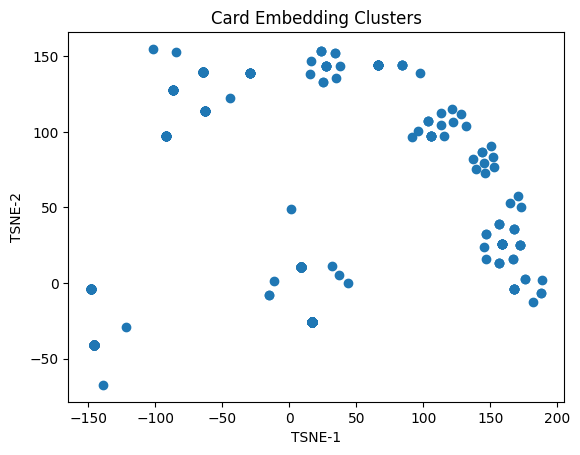

Similarity to Meta Decks: 1.0000


In [ ]:
# Generate embeddings
embeddings = []
for deck_graph in deck_graphs:
    embeddings.append(predict_synergy(model, deck_graph, card_data))

# Visualize embeddings
visualize_embeddings(embeddings)

# Compare generated deck to meta decks (example usage)
meta_decks = [predict_synergy(model, deck, card_data) for deck in deck_graphs]  # Simulating meta decks
similarity_score = compare_deck_to_meta(embeddings[0], meta_decks)
print(f"Similarity to Meta Decks: {similarity_score:.4f}")